In [98]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 data/Mir.csv.bz2


In [100]:
name_dataset = 'Ekonomika'

### load data

In [101]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(67453, 6)
CPU times: user 26.7 s, sys: 3.47 s, total: 30.1 s
Wall time: 25.1 s


In [102]:
df.head()

,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 08:04:00,"""Экономика""",- Рост ВВП России в 2008 году может составить...,Экономика,рост ввп россии в году может составить заяви...,"['рост', 'ввп', 'россия', 'составить', 'журнал..."
1,2008-02-11 08:43:00,"""Экономика""",- Цены на нефть выросли в понедельник после з...,Экономика,цены на нефть выросли в понедельник после заяв...,"['цена', 'нефть', 'вырасти', 'заявление', 'вен..."
2,2008-02-11 09:34:00,"""Экономика""",- Microsoft Corp. после получения официальног...,Экономика,microsoft corp после получения официального от...,"['microsoft', 'corp', 'получение', 'официальны..."
3,2008-02-11 17:29:00,"""Экономика""","- Официальный представитель \""Газпрома\"" (РТС...",Экономика,официальный представитель \газпрома\ ртс gazp ...,"['официальный', 'газпром', 'ртс', 'gazp', 'сер..."
4,2008-02-11 17:35:00,"""Экономика""",- Россия в понедельник официально вступила в ...,Экономика,россия в понедельник официально вступила в ряд...,"['россия', 'официально', 'вступить', 'ряд', 'с..."


* parse data

In [103]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 08:04:00,"""Экономика""",- Рост ВВП России в 2008 году может составить...,Экономика,рост ввп россии в году может составить заяви...,"['рост', 'ввп', 'россия', 'составить', 'журнал...",2008,2
1,2008-02-11 08:43:00,"""Экономика""",- Цены на нефть выросли в понедельник после з...,Экономика,цены на нефть выросли в понедельник после заяв...,"['цена', 'нефть', 'вырасти', 'заявление', 'вен...",2008,2
2,2008-02-11 09:34:00,"""Экономика""",- Microsoft Corp. после получения официальног...,Экономика,microsoft corp после получения официального от...,"['microsoft', 'corp', 'получение', 'официальны...",2008,2
3,2008-02-11 17:29:00,"""Экономика""","- Официальный представитель \""Газпрома\"" (РТС...",Экономика,официальный представитель \газпрома\ ртс gazp ...,"['официальный', 'газпром', 'ртс', 'gazp', 'сер...",2008,2
4,2008-02-11 17:35:00,"""Экономика""",- Россия в понедельник официально вступила в ...,Экономика,россия в понедельник официально вступила в ряд...,"['россия', 'официально', 'вступить', 'ряд', 'с...",2008,2


In [104]:
df.year.value_counts()

2015    9144
2014    8654
2009    7535
2013    7130
2018    6810
2016    6361
2008    5931
2010    4902
2017    4831
2011    3094
2012    2788
2019     273
Name: year, dtype: int64

In [105]:
df.month.value_counts()

10    6509
9     6442
12    6364
3     5916
6     5732
4     5674
11    5658
7     5487
8     5158
2     5085
1     4946
5     4482
Name: month, dtype: int64

In [106]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

* add docID

In [107]:
df['docID'] = list(range(df.shape[0]))

In [108]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырасти, заявление, венесуэла, у..."


In [109]:
print(df.shape)
df.isnull().sum()

(67453, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [110]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [111]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


KeyError: 'url'

* clean text

In [112]:
import preprocessing_tools as pr

In [113]:
%%time
df.text = df.text.apply(pr.clean_text)

AttributeError: 'DataFrame' object has no attribute 'text'

In [114]:
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырасти, заявление, венесуэла, у..."


* cleanedNames

In [115]:
from cleanedNames import KeyProc
cn = KeyProc()

In [116]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

AttributeError: 'DataFrame' object has no attribute 'text'

* lemmatization

In [117]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

AttributeError: 'DataFrame' object has no attribute 'text'

* add docID

In [118]:
df['docID'] = list(range(df.shape[0]))

In [119]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырасти, заявление, венесуэла, у..."


In [120]:
print(df.shape)
df.isnull().sum()

(67453, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [121]:
df.year.min()

2008

## model

* prepare

In [122]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 856 ms, sys: 276 ms, total: 1.13 s
Wall time: 958 ms


In [123]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [124]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Ekonomika", num_batches=72)
CPU times: user 32.9 s, sys: 865 ms, total: 33.7 s
Wall time: 4.94 s


In [125]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [126]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=c3adbfd8-88f7-4859-824a-e041e490da7c, num_entries=24662)

In [127]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [129]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 10
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

#topic 10.........
	SparsityThetaScore: 0.570121169090271
	SparsityPhiScore: 0.7776498198509216
	PerplexityScore: 2572.914794921875
	time: 0:01:26.304539
#topic 11.........
	SparsityThetaScore: 0.5953150391578674
	SparsityPhiScore: 0.7888617515563965
	PerplexityScore: 2528.815673828125
	time: 0:01:35.095959
#topic 12.........
	SparsityThetaScore: 0.61308354139328
	SparsityPhiScore: 0.8032431602478027
	PerplexityScore: 2460.04052734375
	time: 0:01:37.474724
#topic 13.........
	SparsityThetaScore: 0.6301912665367126
	SparsityPhiScore: 0.8136560320854187
	PerplexityScore: 2391.864990234375
	time: 0:01:37.627971
#topic 14.........
	SparsityThetaScore: 0.6411808729171753
	SparsityPhiScore: 0.8221150040626526
	PerplexityScore: 2364.666015625
	time: 0:01:40.709867
#topic 15.........
	SparsityThetaScore: 0.6575936079025269
	SparsityPhiScore: 0.8306246995925903
	PerplexityScore: 2318.347412109375
	time: 0:01:46.003327
#topic 16.........
	SparsityThetaScore: 0.667525589466095
	SparsityPhiScore: 

In [ ]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

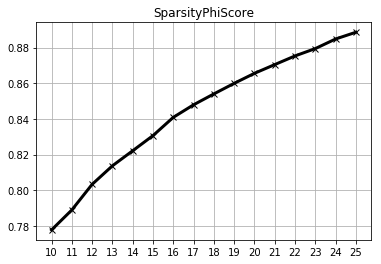

In [130]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [131]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.7, 0.8]

In [132]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.7: 2, 0.8: 14}

Text(0.5, 1.0, 'SparsityThetaScore')

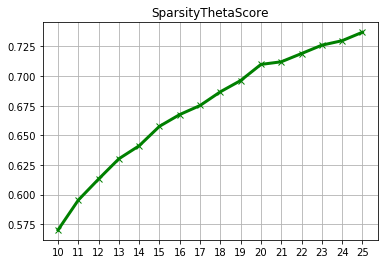

In [133]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [134]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.5, 0.6, 0.7]

In [135]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.5: 2, 0.6: 8, 0.7: 6}

Text(0.5, 1.0, 'PerplexityScore')

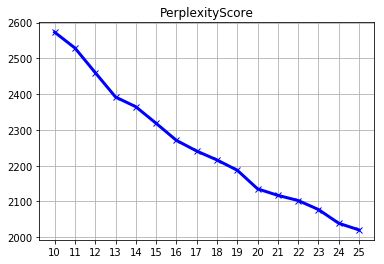

In [136]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [137]:
perplexity

[2572.914794921875,
 2528.815673828125,
 2460.04052734375,
 2391.864990234375,
 2364.666015625,
 2318.347412109375,
 2270.662353515625,
 2240.845703125,
 2215.93017578125,
 2187.21142578125,
 2135.2373046875,
 2116.99462890625,
 2102.580322265625,
 2077.44287109375,
 2038.9830322265625,
 2020.4337158203125]

### select the best model

In [138]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.7: 2, 0.8: 14}
d_stheta: {0.5: 2, 0.6: 8, 0.7: 6}


In [139]:
select_topics = 25 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

25


---

In [ ]:
'''
select_topics = 20

num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()
print(f'best_model.num_topics:{best_model.num_topics}')
'''

---

### print top words for each topics

In [140]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['валюта' 'рейтинг' 'триллион' 'облигация' 'минфин' 'доходность'
 'иностранный' 'дефицит' 'валютный' 'национальный']
topic_1: ['акционер' 'втб' 'русало' 'пакет' 'председатель' 'оао' 'владеть'
 'санкция' 'пост' 'принадлежать']
topic_2: ['ввп' 'инфляция' 'темп' 'потребительский' 'выражение' 'минэкономразвития'
 'безработица' 'расход' 'прогнозировать' 'росстат']
topic_3: ['информация' 'услуга' 'карта' 'клиент' 'лицо' 'закон' 'деятельность'
 'требование' 'оператор' 'платёжный']
topic_4: ['банковский' 'резерв' 'сектор' 'мвф' 'поддержка' 'кредит' 'кредитный'
 'портфель' 'программа' 'ликвидность']
topic_5: ['украина' 'газа' 'газпром' 'газ' 'украинский' 'тариф' 'кубометр'
 'газовый' 'контракт' 'транзит']
topic_6: ['добыча' 'фьючерс' 'опека' 'запас' 'brent' 'wti' 'товарный' 'нефтяной'
 'бс' 'контракт']
topic_7: ['очень' 'деньга' 'хороший' 'нужно' 'поэтому' 'например' 'делать' 'просто'
 'сделать' 'главный']
topic_8: ['авиакомпания' 'аэрофлот' 'британский' 'аэропорт' 'самолёт' 'фунт' 'ре

### get topics-docs matrix

shape theta: (25, 71288)


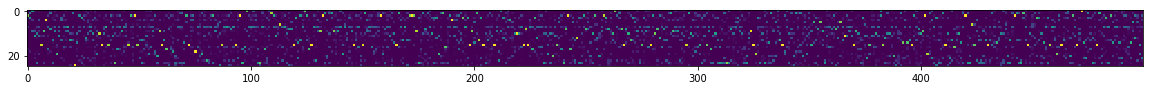

In [141]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [142]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
32000,0.000000,0.000000,0.030644,0.000000,0.118553,0.0,0.0,0.578858,0.000000,0.016706,...,0.000000,0.091662,0.00000,0.01055,0.000000,0.0000,0.000000,0.003533,0.000531,0.001600
32001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.970344,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
32002,0.000000,0.007421,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.029233,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.013713,0.0000,0.000000,0.000000,0.218044,0.066405
32003,0.020559,0.000000,0.000000,0.184251,0.000000,0.0,0.0,0.085049,0.000000,0.000000,...,0.000000,0.000000,0.23309,0.00000,0.000000,0.0362,0.000000,0.000000,0.265459,0.000000
32004,0.000000,0.189997,0.000000,0.000000,0.000000,0.0,0.0,0.007959,0.579202,0.081613,...,0.000000,0.000000,0.00000,0.00000,0.033006,0.0000,0.078636,0.029585,0.000000,0.000000


## DataViz

In [143]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,0,2008,2,0.125873,0.000000,0.387315,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.054791,0.000000,0.000000,0.0,0.185066,0.0
1,1,2008,2,0.000000,0.000000,0.017058,0.000000,0.0,0.000000,0.441644,...,0.000000,0.000000,0.0,0.0,0.000000,0.300162,0.000000,0.0,0.000000,0.0
2,2,2008,2,0.000000,0.040753,0.000000,0.077637,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.006924,0.000000,0.000000,0.0,0.000000,0.0
3,3,2008,2,0.000000,0.000000,0.000000,0.000000,0.0,0.936398,0.000000,...,0.063602,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,4,2008,2,0.064323,0.000000,0.008286,0.000000,0.0,0.023143,0.033544,...,0.000000,0.003737,0.0,0.0,0.000000,0.354513,0.079156,0.0,0.074179,0.0


In [144]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 25)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 2       1.691675   4.263881   5.423926   4.365567   1.951763  11.547796   
     3      10.474305  14.666745  13.816173  10.713355  12.650717  28.632013   
     4       3.156591  23.799109  17.731436  11.009442  10.338297  10.998729   
     5       1.493849  17.802893  26.031250   7.278816   4.731328  10.364894   
     6       6.310491  39.742214  26.192127  14.572848   7.133217   8.968452   

              topic_6    topic_7    topic_8   topic_9    ...       topic_15  \
year month                                               ...                  
2008 2       6.873462   5.687275   3.368960  2.025960    ...       5.740960   
     3      13.400686  16.833502  18.437962  5.192722    ...      13.001351   
     4      12.365722  13.477382  23.354746  5.138438    ...       5.532024   
     5      20.383343  11.083273   8.046310  3.596715    ...       9.417171   
     6      11.742636  20.623877   8.458692  2.946073    ...       4.406090   

             topic_16   topic_17  topic_18   topic_19   topic_20  topic_21  \
year month                                                                   
2008 2       1.840996   1.363933  1.647060   4.672269   5.998037  2.336765   
     3      10.416106  11.612933  6.034095  12.237546  13.289175  6.277801   
     4       7.312335   8.805345  5.108537   5.204667  15.675827  5.798349   
     5       7.306411   7.263341  2.990981   3.450984  14.140712  3.058848   
     6       8.267466   9.929105  6.326449   3.162540  20.560692  5.880312   

            topic_22   topic_23   topic_24  
year month                                  
2008 2      3.441403  10.678805   2.045808  
     3      9.216504  27.262026   8.876478  
     4      4.832606  25.819605   7.485976  
     5      7.536322  28.821178   8.931253  
     6      7.642062  37.967682  12.930219  

[5 rows x 25 columns]

### straightforward matrix heatmap

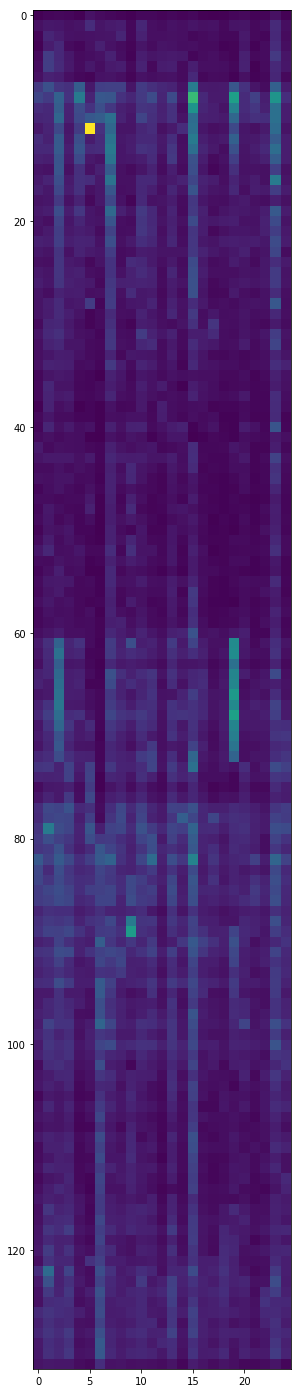

In [145]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [146]:
import pygal
from IPython.display import SVG, HTML

html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [147]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [148]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [149]:
import joypy # !pip install joypy

In [150]:
print(joined.shape)
joined.head()

(67453, 28)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,0,2008,2,0.125873,0.000000,0.387315,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.054791,0.000000,0.000000,0.0,0.185066,0.0
1,1,2008,2,0.000000,0.000000,0.017058,0.000000,0.0,0.000000,0.441644,...,0.000000,0.000000,0.0,0.0,0.000000,0.300162,0.000000,0.0,0.000000,0.0
2,2,2008,2,0.000000,0.040753,0.000000,0.077637,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.006924,0.000000,0.000000,0.0,0.000000,0.0
3,3,2008,2,0.000000,0.000000,0.000000,0.000000,0.0,0.936398,0.000000,...,0.063602,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,4,2008,2,0.064323,0.000000,0.008286,0.000000,0.0,0.023143,0.033544,...,0.000000,0.003737,0.0,0.0,0.000000,0.354513,0.079156,0.0,0.074179,0.0


In [151]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,date
0,0,2008,2,0.125873,0.000000,0.387315,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.054791,0.000000,0.000000,0.0,0.185066,0.0,2008-02-01
1,1,2008,2,0.000000,0.000000,0.017058,0.000000,0.0,0.000000,0.441644,...,0.000000,0.0,0.0,0.000000,0.300162,0.000000,0.0,0.000000,0.0,2008-02-01
2,2,2008,2,0.000000,0.040753,0.000000,0.077637,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.006924,0.000000,0.000000,0.0,0.000000,0.0,2008-02-01
3,3,2008,2,0.000000,0.000000,0.000000,0.000000,0.0,0.936398,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2008-02-01
4,4,2008,2,0.064323,0.000000,0.008286,0.000000,0.0,0.023143,0.033544,...,0.003737,0.0,0.0,0.000000,0.354513,0.079156,0.0,0.074179,0.0,2008-02-01


In [152]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()

dd2=dd2.reset_index()

dd.head()

,date,topic,mentions
0,2008-02-01,topic_0,0.125873
4,2008-02-01,topic_0,0.064323
12,2008-02-01,topic_0,0.035298
20,2008-02-01,topic_0,0.032262
21,2008-02-01,topic_0,0.036640


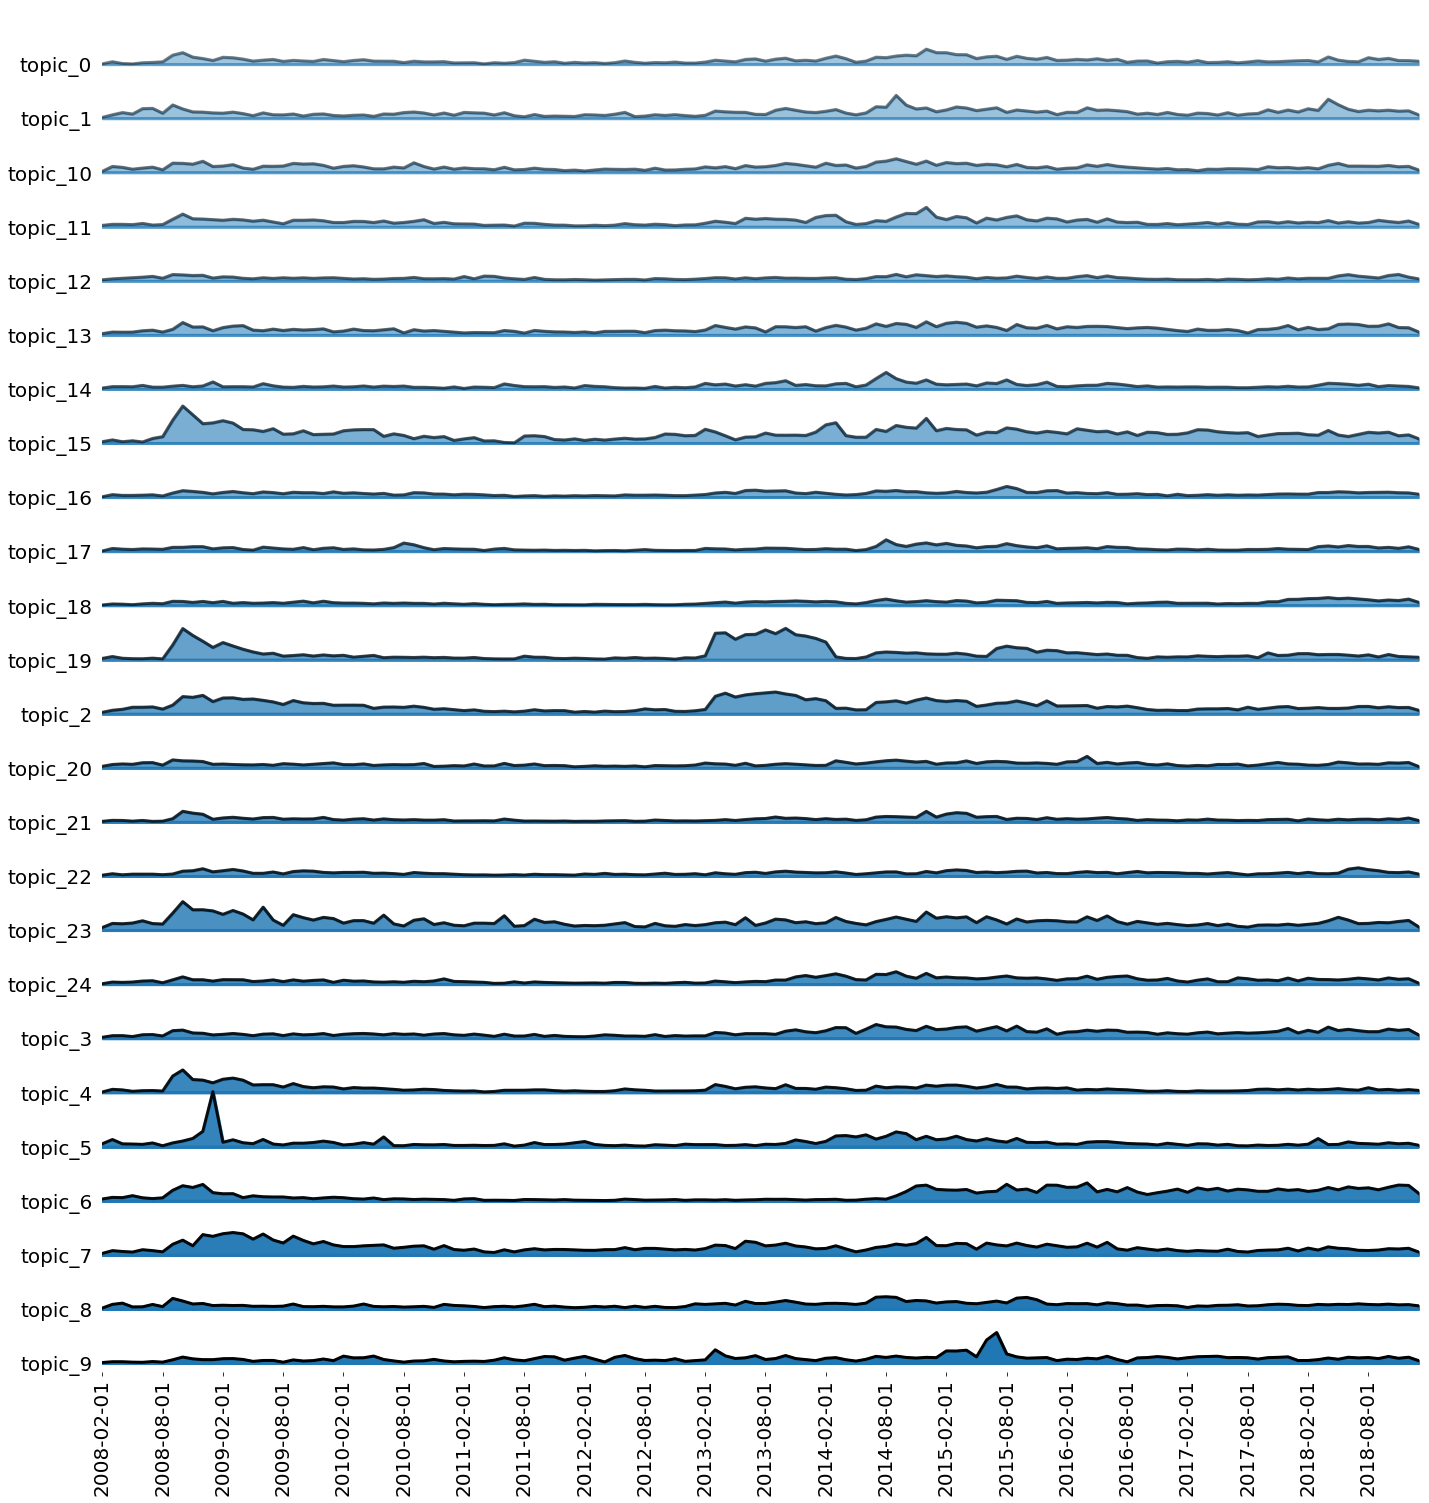

In [153]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [154]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")